# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.cluster import adjusted_rand_score, rand_score

from scipy import stats

In [2]:
customers_df = pd.read_csv("data/olist_customers_dataset.csv")
geolocation_df = pd.read_csv("data/olist_geolocation_dataset.csv")
order_items_df = pd.read_csv("data/olist_order_items_dataset.csv")
order_payments_df = pd.read_csv("data/olist_order_payments_dataset.csv")
order_reviews_df = pd.read_csv("data/olist_order_reviews_dataset.csv")
orders_df = pd.read_csv("data/olist_orders_dataset.csv")
products_df = pd.read_csv("data/olist_products_dataset.csv")
sellers_df = pd.read_csv("data/olist_sellers_dataset.csv")
translation_df = pd.read_csv("data/product_category_name_translation.csv")

Dataframe containing cluster label predicted for each client :

In [3]:
results_df = pd.read_csv("results.csv")

# Utils

In [4]:
def dataset_aggregate(start_date, end_date):

    """

    Creates a dataframe : a line for each client with its orders between start date and end date

    """

    orders_df_bis = orders_df[
        (orders_df["order_purchase_timestamp"] >= start_date)
        & (orders_df["order_purchase_timestamp"] <= end_date)
    ]

    final_customers_df = pd.DataFrame({
        "customer_id": customers_df["customer_unique_id"],
        "customer_state": customers_df["customer_state"],
    })

    df_merge_customers_orders = pd.merge(customers_df, orders_df_bis, on=["customer_id"], how="inner")
    dict_nb_orders = dict(df_merge_customers_orders.customer_unique_id.value_counts())
    final_customers_df["nb_orders"] = final_customers_df["customer_id"].map(dict_nb_orders)

    df_merge_items_customers_orders = pd.merge(order_items_df, df_merge_customers_orders, on="order_id", how="inner")

    df_nb_products = df_merge_items_customers_orders.groupby("customer_unique_id").product_id.count()
    df_nb_items = df_merge_items_customers_orders.groupby("customer_unique_id").order_item_id.sum()
    df_price = df_merge_items_customers_orders.groupby("customer_unique_id").price.mean()
    df_freight_value = df_merge_items_customers_orders.groupby("customer_unique_id").freight_value.mean()

    final_customers_df["mean_items_per_order"] = final_customers_df["customer_id"].map(dict(df_nb_items))/final_customers_df["nb_orders"]
    final_customers_df["mean_price_per_product_ordered"] = final_customers_df["customer_id"].map(dict(df_price))
    final_customers_df["mean_freight_value_per_product_ordered"] = final_customers_df["customer_id"].map(dict(df_freight_value))    

    df_merge_payments_customers_orders = pd.merge(order_payments_df, df_merge_customers_orders, on="order_id", how="inner")

    df_payment_installments = df_merge_payments_customers_orders.groupby("customer_unique_id").payment_installments.mean()
    df_payment_type = df_merge_payments_customers_orders.groupby("customer_unique_id").payment_type.agg(lambda x: x.mode()[0])

    final_customers_df["most_frequent_payment_type"] = final_customers_df["customer_id"].map(dict(df_payment_type))
    final_customers_df["mean_payment_installments"] = final_customers_df["customer_id"].map(dict(df_payment_installments))

    df_merge_reviews_customers_orders = pd.merge(order_reviews_df, df_merge_customers_orders, on="order_id", how="inner")
    df_reviews = df_merge_reviews_customers_orders.groupby("customer_unique_id").review_score.mean()
    final_customers_df["mean_review_score"] = final_customers_df["customer_id"].map(dict(df_reviews))

    df_merge_items_customers_orders = pd.merge(order_items_df, df_merge_customers_orders, on="order_id", how="inner")

    df_merge_products_items_customers_orders = pd.merge(products_df, df_merge_items_customers_orders, on="product_id", how="inner")
    df_merge_translation_products_items_customers_orders = pd.merge(translation_df, df_merge_products_items_customers_orders, on="product_category_name", how="inner")

    df_nb_products = df_merge_items_customers_orders.groupby("customer_unique_id").product_id.count()
    df_nb_items = df_merge_items_customers_orders.groupby("customer_unique_id").order_item_id.sum()
    df_price = df_merge_items_customers_orders.groupby("customer_unique_id").price.mean()
    df_freight_value = df_merge_items_customers_orders.groupby("customer_unique_id").freight_value.mean()

    final_customers_df["mean_items_per_order"] = final_customers_df["customer_id"].map(dict(df_nb_items))/final_customers_df["nb_orders"]
    final_customers_df["mean_price_per_product_ordered"] = final_customers_df["customer_id"].map(dict(df_price))
    final_customers_df["mean_freight_value_per_product_ordered"] = final_customers_df["customer_id"].map(dict(df_freight_value))    

    df_merge_payments_customers_orders = pd.merge(order_payments_df, df_merge_customers_orders, on="order_id", how="inner")
    df_payment_installments = df_merge_payments_customers_orders.groupby("customer_unique_id").payment_installments.mean()
    df_payment_type = df_merge_payments_customers_orders.groupby("customer_unique_id").payment_type.agg(lambda x: x.mode()[0])

    final_customers_df["most_frequent_payment_type"] = final_customers_df["customer_id"].map(dict(df_payment_type))
    final_customers_df["mean_payment_installments"] = final_customers_df["customer_id"].map(dict(df_payment_installments))

    df_merge_reviews_customers_orders = pd.merge(order_reviews_df, df_merge_customers_orders, on="order_id", how="inner")
    df_reviews = df_merge_reviews_customers_orders.groupby("customer_unique_id").review_score.mean()

    final_customers_df["mean_review_score"] = final_customers_df["customer_id"].map(dict(df_reviews))

    df_merge_products_items_customers_orders = pd.merge(products_df, df_merge_items_customers_orders, on="product_id", how="inner")
    df_merge_translation_products_items_customers_orders = pd.merge(translation_df, df_merge_products_items_customers_orders, on="product_category_name", how="inner")

    df_product_category_name = df_merge_translation_products_items_customers_orders.groupby("customer_unique_id").product_category_name_english.agg(lambda x: x.mode()[0])
    df_weight = df_merge_translation_products_items_customers_orders.groupby("customer_unique_id").product_weight_g.mean()

    final_customers_df["most_frequent_product_category"] = final_customers_df["customer_id"].map(dict(df_product_category_name))
    final_customers_df["mean_weight_per_product_ordered"] = final_customers_df["customer_id"].map(dict(df_weight))/1000

    df_unavailable = df_merge_customers_orders.groupby('customer_unique_id').apply(lambda x: (x['order_status'] == 'unavailable').sum())
    df_canceled = df_merge_customers_orders.groupby('customer_unique_id').apply(lambda x: (x['order_status'] == 'canceled').sum())

    df_merge_customers_orders.delivery_date = pd.to_datetime(df_merge_customers_orders.order_delivered_customer_date)
    df_merge_customers_orders.estimated_delivery_date = pd.to_datetime(df_merge_customers_orders.order_estimated_delivery_date)
    df_merge_customers_orders.purchase_date = pd.to_datetime(df_merge_customers_orders.order_purchase_timestamp)


    df_merge_customers_orders["delay"] = (df_merge_customers_orders.delivery_date - df_merge_customers_orders.estimated_delivery_date).dt.days
    df_merge_customers_orders["delivery_time"] = (df_merge_customers_orders.delivery_date - df_merge_customers_orders.purchase_date).dt.days 

    df_delay = df_merge_customers_orders.groupby("customer_unique_id")["delay"].mean()
    df_delivery_time = df_merge_customers_orders.groupby("customer_unique_id")["delivery_time"].mean()

    final_customers_df["mean_delay"] = final_customers_df["customer_id"].map(dict(df_delay))
    final_customers_df["mean_delivery_time"] = final_customers_df["customer_id"].map(dict(df_delivery_time))

    last_purchase_date = pd.to_datetime(df_merge_customers_orders.sort_values(by="order_purchase_timestamp" ,ascending=False).iloc[0].order_purchase_timestamp)
    df_merge_customers_orders["recency"] = (last_purchase_date - df_merge_customers_orders.purchase_date).dt.days

    df_recency = df_merge_customers_orders.groupby("customer_unique_id")["recency"].min()

    final_customers_df["recency"] = final_customers_df["customer_id"].map(dict(df_recency))

    final_customers_df.dropna(inplace=True)

    return final_customers_df


# Training the model

In [5]:
# the dataframe used for training
df_0 = dataset_aggregate("2017-01-01", "2017-12-31")

/tmp/ipykernel_8836/202848382.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_unavailable = df_merge_customers_orders.groupby('customer_unique_id').apply(lambda x: (x['order_status'] == 'unavailable').sum())
/tmp/ipykernel_8836/202848382.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_canceled = df_merge_customers_orders.groupby('customer_unique_id').apply(lambda x: (x['order_status'] == 'ca

In [6]:
df_0.shape

(43134, 14)

In [7]:
def process_cv(pipeline, param_grid, X_train):
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, refit=True)
    grid_search.fit(X_train)
    
    return grid_search

Pipeline for training

In [8]:
k=4

X_train = df_0[["recency", "nb_orders", "mean_price_per_product_ordered"]]

numeric_features = ["recency", "nb_orders", "mean_price_per_product_ordered"]
categorical_features = []

scaler = StandardScaler()

kmeans_opti = KMeans()
#dbscan = DBSCAN()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Standardiser les variables numériques
        ('cat', OneHotEncoder(), categorical_features)  # Encoder les variables catégorielles
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clusterer', KMeans())
])
param_grid_kmeans_opti = [
    {
        'clusterer': [KMeans()],
        'clusterer__n_clusters': [k],
        'clusterer__init': ['k-means++', 'random'],
        'clusterer__n_init': [10]
    },

]

pipeline_kmeans_opti = Pipeline([
    ('preprocessor', preprocessor), 
    ('clusterer', kmeans_opti)
])

In [11]:
grid_search_kmeans = process_cv(pipeline_kmeans_opti, param_grid_kmeans_opti, X_train)

# Iteration : predictions adding customers week per week

In [12]:
data = []
df_ARI = pd.DataFrame(data, columns=['end_date', 'adjusted_ARI', 'nb_multiorders'])

end_dates = pd.date_range(start="2018-01-01",end="2018-04-01", freq="W").to_pydatetime().tolist()
     

In [13]:
start = '01-01-2017'
for date in end_dates:
    end_Tn = str(date)

    df_Tn = dataset_aggregate(start, end_Tn)

    clusters_Tn = grid_search_kmeans.predict(df_Tn[["nb_orders", "recency", "mean_price_per_product_ordered"]])
    df_Tn['kmeans_RFM_Tn'] = clusters_Tn

    df_final = results_df[['customer_id','kmeans_RFM']].merge(
                      df_Tn[['customer_id','kmeans_RFM_Tn']], on='customer_id', how='right')

    ARI_adj = adjusted_rand_score(df_final['kmeans_RFM'], df_final['kmeans_RFM_Tn'])
    ARI = rand_score(df_final['kmeans_RFM'], df_final['kmeans_RFM_Tn'])

    nb_clients = len(df_Tn)

    nb_multiorders = len(df_Tn[df_Tn['nb_orders'] > 1])

    new_row = {'end_date':end_Tn, 'ARI':ARI, 'adjusted_ARI':ARI_adj, 'nb_clients':nb_clients, 'nb_multiorders':nb_multiorders}

    df_ARI = pd.concat([df_ARI, pd.DataFrame([new_row])], ignore_index=True)
     

/tmp/ipykernel_8836/202848382.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_unavailable = df_merge_customers_orders.groupby('customer_unique_id').apply(lambda x: (x['order_status'] == 'unavailable').sum())
/tmp/ipykernel_8836/202848382.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_canceled = df_merge_customers_orders.groupby('customer_unique_id').apply(lambda x: (x['order_status'] == 'ca

In [14]:
df_final

,customer_id,kmeans_RFM,kmeans_RFM_Tn
0,861eff4711a542e4b93843c6dd7febb0,4,2
1,290c77bc529b7ac935b93aa66c333dc3,0,1
2,259dac757896d24d7702b9acbbff3f3c,1,1
3,4c93744516667ad3b8f1fb645a3116a4,2,0
4,4c93744516667ad3b8f1fb645a3116a4,2,0
...,...,...,...
70232,d111b06b6f3a2add0d2241325f65b5ca,0,1
70233,e7f8760e2bbd2f1986bebd99596c088e,4,2
70234,4b5820135d360a45552b5163835b1d89,0,1
70235,73c2643a0a458b49f58cea58833b192e,6,3


In [15]:
df_ARI

,end_date,adjusted_ARI,nb_multiorders,ARI,nb_clients
0,2018-01-07 00:00:00,0.638268,2782,0.833387,44583.0
1,2018-01-14 00:00:00,0.693587,2874,0.858861,46241.0
2,2018-01-21 00:00:00,0.750955,3004,0.885313,47925.0
3,2018-01-28 00:00:00,0.800606,3119,0.908163,49458.0
4,2018-02-04 00:00:00,0.849859,3216,0.930815,50941.0
5,2018-02-11 00:00:00,0.819751,3336,0.916898,52469.0
6,2018-02-18 00:00:00,0.775807,3463,0.896587,53989.0
7,2018-02-25 00:00:00,0.739607,3594,0.879763,55644.0
8,2018-03-04 00:00:00,0.707534,3757,0.864836,57466.0
9,2018-03-11 00:00:00,0.677170,3868,0.850665,59011.0


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, '2018-01-07 00:00:00'),
  Text(1, 0, '2018-01-14 00:00:00'),
  Text(2, 0, '2018-01-21 00:00:00'),
  Text(3, 0, '2018-01-28 00:00:00'),
  Text(4, 0, '2018-02-04 00:00:00'),
  Text(5, 0, '2018-02-11 00:00:00'),
  Text(6, 0, '2018-02-18 00:00:00'),
  Text(7, 0, '2018-02-25 00:00:00'),
  Text(8, 0, '2018-03-04 00:00:00'),
  Text(9, 0, '2018-03-11 00:00:00'),
  Text(10, 0, '2018-03-18 00:00:00'),
  Text(11, 0, '2018-03-25 00:00:00'),
  Text(12, 0, '2018-04-01 00:00:00')])

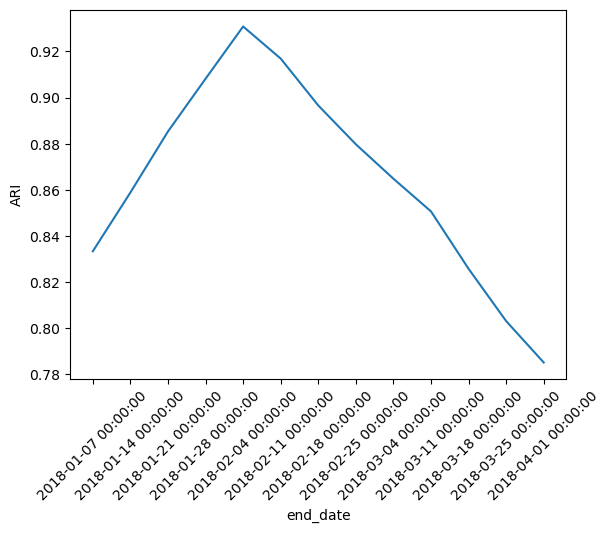

In [16]:
sns.lineplot(x='end_date', y='ARI', data=df_ARI)
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, '2018-01-07 00:00:00'),
  Text(1, 0, '2018-01-14 00:00:00'),
  Text(2, 0, '2018-01-21 00:00:00'),
  Text(3, 0, '2018-01-28 00:00:00'),
  Text(4, 0, '2018-02-04 00:00:00'),
  Text(5, 0, '2018-02-11 00:00:00'),
  Text(6, 0, '2018-02-18 00:00:00'),
  Text(7, 0, '2018-02-25 00:00:00'),
  Text(8, 0, '2018-03-04 00:00:00'),
  Text(9, 0, '2018-03-11 00:00:00'),
  Text(10, 0, '2018-03-18 00:00:00'),
  Text(11, 0, '2018-03-25 00:00:00'),
  Text(12, 0, '2018-04-01 00:00:00')])

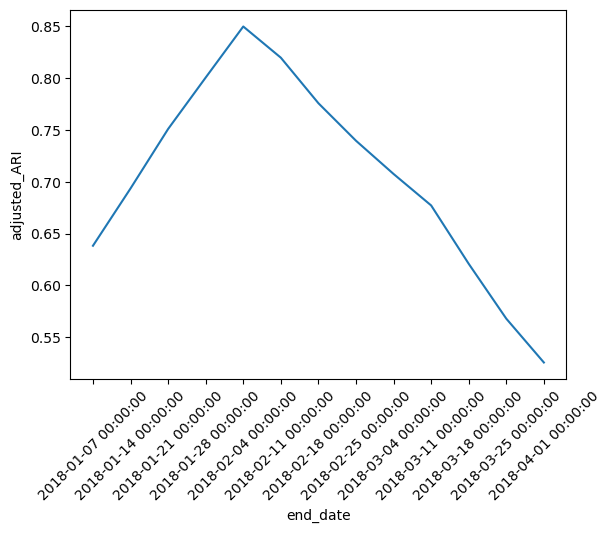

In [17]:
sns.lineplot(x='end_date', y='adjusted_ARI', data=df_ARI)
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, '2018-01-07 00:00:00'),
  Text(1, 0, '2018-01-14 00:00:00'),
  Text(2, 0, '2018-01-21 00:00:00'),
  Text(3, 0, '2018-01-28 00:00:00'),
  Text(4, 0, '2018-02-04 00:00:00'),
  Text(5, 0, '2018-02-11 00:00:00'),
  Text(6, 0, '2018-02-18 00:00:00'),
  Text(7, 0, '2018-02-25 00:00:00'),
  Text(8, 0, '2018-03-04 00:00:00'),
  Text(9, 0, '2018-03-11 00:00:00'),
  Text(10, 0, '2018-03-18 00:00:00'),
  Text(11, 0, '2018-03-25 00:00:00'),
  Text(12, 0, '2018-04-01 00:00:00')])

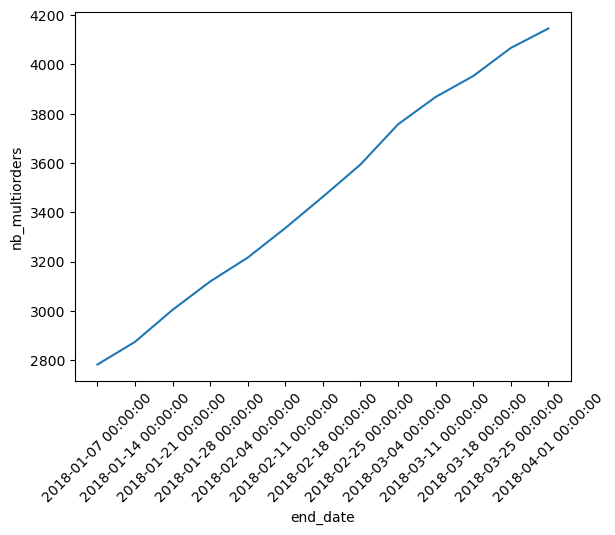

In [18]:
sns.lineplot(x='end_date', y='nb_multiorders', data=df_ARI)
plt.xticks(rotation=45)

In [19]:
sns.lineplot(x='date_fin', y='nb_clients', data=df_ARI)
plt.xticks(rotation=45)

ValueError: Could not interpret value `date_fin` for `x`. An entry with this name does not appear in `data`.

## Kolmogorov-Smirnov tests between training dataset and updated dataset

In [25]:
for variable in ["nb_orders", "mean_price_per_product_ordered", "recency"]:
    
    ks_stat, p_value = stats.kstest(df_0[variable], df_Tn[variable])
    print(variable, ": ")
    print(f"Statistique KS: {ks_stat}")
    print(f"P-valeur: {p_value}")
    print("\n")

nb_orders : 
Statistique KS: 0.0026999440911200656
P-valeur: 0.9917827509883729


mean_price_per_product_ordered : 
Statistique KS: 0.0074397608140896465
P-valeur: 0.11576022238687667


recency : 
Statistique KS: 0.11139655541844584
P-valeur: 3.720600201867962e-278


